# **[IntoAI] WEEK2 : Uninformed Search Algorithm**

##### **학습 목표 : 문제의 정의 외에 문제에 대한 정보를 갖지 않고 검색 공간을 탐색하는 검색 알고리즘인 Uniformed Search Algorithm을 학습하고 이에 대한 파이썬 구현 예제를 *살펴본다*.**

### **목차**
1. 문제 정의
2. 그래프 표현
3. BFS(Breadth First Search)
4. DFS(Depth First Search)
5. DLS(Depth Limited Search)
6. IDS(Iterative Deepning Search)


*인공지능 : 현대적 접근방식(제4판)* 도서를 기반으로 작성되었으며 https://github.com/aimacode/aima-python 을 참고하였습니다.
* **Chapter3 | 검색을 통한 문제 해결** 의 내용을 포함하고 있습니다.
* 코드와 이론에 대한 자세한 설명은 (블로그 링크)를 참고하세요.
* **Google Colab**을 기반으로 작동하도록 제작되었습니다.
* notebook을 실행하기 위해서는 **search.py, utils.py, notebook.py** 모듈이 포함되어야 합니다.
* 무단 복제 및 배포를 금합니다.




---



### **0. 기본 환경 세팅**

In [29]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 모듈이 들어있는 디렉토리로 이동하기
%cd drive/MyDrive/TA/인공지능 입문/SCS4033_Introduce-to-AI/Week 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/TA/인공지능 입문/SCS4033_Introduce-to-AI/Week 2'
/content/drive/MyDrive/TA/인공지능 입문/SCS4033_Introduce-to-AI/Week 2


In [30]:
# seach.py와 notebook.py 모듈에서 제공하는 다양한 라이브러리를 불러옵니다
from search import *
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# matplotlib 섹션에서 경고를 숨기는 데 필요합니다.
import warnings
warnings.filterwarnings("ignore")

# 시각화를 위한 라이브러리를 불러옵니다.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

### **1. 문제 정의**

search.py 모듈에서 Problem의 정의 살펴보기

In [31]:
psource(Problem)

이 코드는 인공지능 분야에서 자주 사용되는 검색 문제를 해결하기 위한 프레임워크를 제공하는 추상 클래스인 Problem 클래스를 정의한 것입니다.

이 클래스는 초기 상태와 목표 상태(해결하고자 하는 문제의 목적)를 포함하는데, 문제를 해결하기 위한 구체적인 방법은 actions, result, goal_test, path_cost 등의 메서드를 구현하는 서브클래스에서 구현합니다.

actions 메서드는 현재 상태에서 가능한 행동(액션)들을 반환하고, result 메서드는 현재 상태에서 주어진 액션을 수행한 결과로 새로운 상태를 반환합니다. goal_test 메서드는 현재 상태가 목표 상태인지 여부를 반환하며, path_cost 메서드는 경로의 비용을 계산합니다. value 메서드는 최적화 문제에서 각 상태의 가치를 계산합니다.

이 클래스는 추상 클래스이므로 직접 인스턴스화할 수 없습니다. 대신 서브클래스를 만들어 actions, result, goal_test, path_cost, value 등을 구현한 후, 인스턴스를 만들어 다양한 검색 함수를 사용하여 문제를 해결할 수 있습니다.

루마니아 지도 : 부카레스트 도착하기

In [32]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

### **2. 그래프 표현**
그래프를 표현하기 위해 Node를 어떻게 정의하는 지 살펴봅니다.

In [33]:
psource(Node)

이 코드는 탐색 알고리즘에서 사용하는 트리 노드를 정의하는 클래스인 Node 클래스를 구현한 것입니다. 각 노드는 문제 상태, 부모 노드, 이전 액션, 누적 비용(path_cost) 등을 가지며, 특정 알고리즘에서 사용하는 추가 정보인 f, h 값도 추가될 수 있습니다.

이 클래스는 다양한 탐색 알고리즘에서 공통으로 사용되며, 문제의 초기 상태에서 시작하여 목표 상태까지 도달하는 경로를 트리로 표현합니다. 이 때, 각 노드는 부모 노드를 참조함으로써 경로를 추적할 수 있습니다.

메서드로는 expand(), child_node(), solution(), path() 등이 있습니다. expand() 메서드는 현재 노드에서 가능한 모든 액션을 적용한 결과를 리스트로 반환합니다. child_node() 메서드는 현재 노드에서 주어진 액션을 적용하여 새로운 자식 노드를 생성합니다. solution() 메서드는 초기 상태에서 현재 노드까지 이르는 액션 시퀀스를 반환합니다. path() 메서드는 초기 상태부터 현재 노드까지 이르는 모든 노드를 리스트로 반환합니다.

또한, 노드의 중복 상태를 피하기 위해 eq()와 hash() 메서드가 정의되어 있습니다. 이 메서드들은 동일한 상태(state)를 가진 노드를 동등하다고 처리하여 중복을 허용하지 않습니다. 이는 너비 우선 탐색(breadth_first_graph_search)이나 A* 알고리즘(astar_search) 등에서 사용됩니다.

In [34]:
psource(GraphProblem)

이 코드는 Problem 클래스를 상속받아 그래프를 탐색하는 문제를 해결하기 위한 GraphProblem 클래스를 정의한 것입니다.

이 클래스는 초기 상태와 목표 상태, 그리고 그래프를 포함합니다. actions 메서드는 현재 노드에서 이동할 수 있는 이웃 노드들을 반환하고, result 메서드는 주어진 액션을 수행하여 새로운 노드를 반환합니다.

path_cost 메서드는 경로의 비용을 계산하는데, 현재 노드에서 주어진 액션으로 이동하여 도착한 노드까지의 비용을 반환합니다. find_min_edge 메서드는 그래프에서 가장 작은 가중치 값을 찾습니다. h 메서드는 현재 노드와 목표 노드 간의 직선 거리(휴리스틱)를 계산합니다.

이 클래스는 locs 속성이 존재하면 노드 간의 위치 정보를 사용하여 휴리스틱을 계산하며, locs 속성이 없으면 무한대 값을 반환합니다.

이 클래스는 그래프 탐색 문제에서 사용되며, 다양한 검색 알고리즘에서 사용될 수 있습니다.

In [35]:
romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

In [36]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

In [37]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


In [38]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

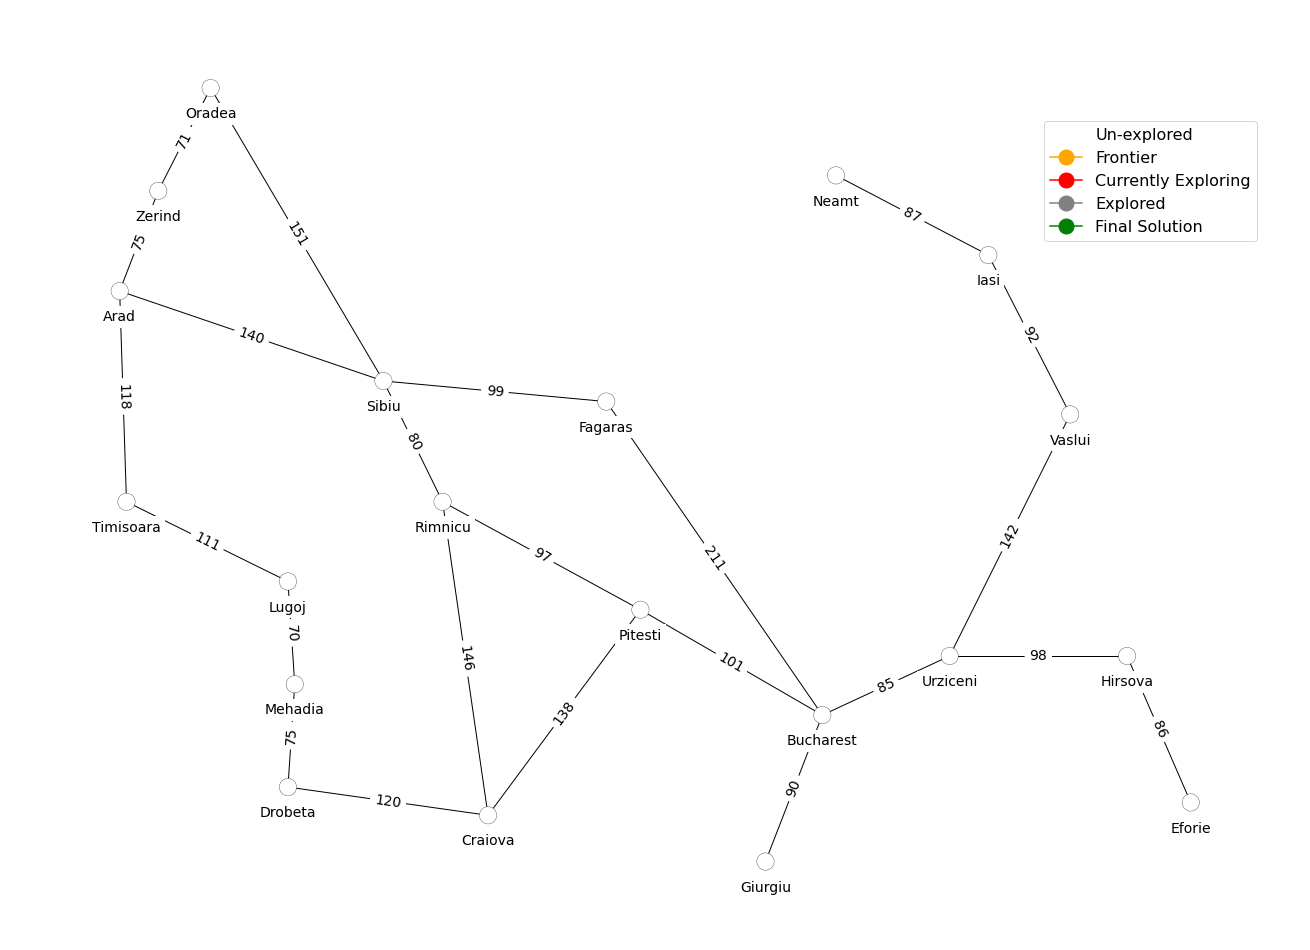

In [39]:
show_map(romania_graph_data)

### **3. Breadth First Search**
문제를 해결하기 위해 BFS를 사용해봅니다.

In [40]:
psource(breadth_first_tree_search)

In [41]:
def tree_breadth_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the queue
    frontier = deque([Node(problem.initial)])
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of queue
        node = frontier.popleft()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    iterations, all_node_colors, node = tree_breadth_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [42]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
a, b, c = breadth_first_tree_search(romania_problem)
display_visual(romania_graph_data, user_input=False, 
               algorithm=breadth_first_tree_search, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### **4. Depth First Search**
문제를 해결하기 위해 DFS를 사용해봅니다.

In [43]:
psource(depth_first_tree_search)

In [44]:
def tree_depth_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the stack
    frontier = [Node(problem.initial)]
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of stack
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def depth_first_tree_search(problem):
    "Search the deepest nodes in the search tree first."
    iterations, all_node_colors, node = tree_depth_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [45]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=depth_first_tree_search, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### **5. Depth Limited Search**
문제를 해결하기 위해 DLS를 사용해봅니다.

In [46]:
psource(depth_limited_search)

depth_limited_search 함수는 주어진 문제에 대한 깊이 제한 탐색 알고리즘을 수행하여 해결책을 찾습니다. 이 알고리즘은 문제의 초기 상태에서 시작하여 깊이가 점점 증가하는 노드를 반복적으로 탐색하며, 해결책을 찾거나 깊이 제한에 도달할 때까지 탐색을 계속합니다.

이 함수는 두 개의 매개변수를 가집니다. problem은 초기 상태, 목표 검사 및 각 상태에서 가능한 동작을 정의하는 문제 클래스의 인스턴스이며, limit은 탐색의 깊이 제한입니다.

함수의 핵심은 recursive_dls 함수입니다. 이 함수는 실제 검색을 수행합니다. node는 현재 탐색 중인 노드이며, problem은 문제 인스턴스, limit은 탐색의 깊이 제한입니다.

현재 노드가 목표 상태인 경우, 함수는 해당 노드를 반환합니다. 깊이 제한에 도달한 경우, 함수는 탐색이 제한되었다는 의미로 문자열 'cutoff'을 반환합니다. 이러한 조건이 모두 충족되지 않은 경우, 함수는 현재 노드를 확장하여 자식 노드를 생성하고, 각 자식 노드에 대해 recursive_dls를 재귀적으로 호출하여 깊이 제한을 1 감소시킵니다.

자식 노드 중 하나라도 'cutoff'를 반환하는 경우, cutoff_occurred를 True로 설정합니다. 자식 노드 중 하나라도 None이 아닌 결과를 반환하는 경우, 해당 결과를 해결책으로 반환합니다. 자식 노드 중 결과가 없는 경우, 함수는 None을 반환합니다.

마지막으로, depth_limited_search는 문제의 초기 상태를 나타내는 Node 객체로 recursive_dls를 호출하고, 검색 결과를 반환합니다.

In [47]:
def depth_limited_search_graph(problem, limit = -1):
    '''
    Perform depth first search of graph g.
    if limit >= 0, that is the maximum depth of the search.
    '''
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [Node(problem.initial)]
    explored = set()
    
    cutoff_occurred = False
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    while frontier:
        # Popping first node of queue
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        elif limit >= 0:
            cutoff_occurred = True
            limit += 1
            all_node_colors.pop()
            iterations -= 1
            node_colors[node.state] = "gray"

        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
        
        for n in frontier:
            limit -= 1
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return 'cutoff' if cutoff_occurred else None


def depth_limited_search_for_vis(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = depth_limited_search_graph(problem)
    return(iterations, all_node_colors, node)     

In [48]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=depth_limited_search_for_vis, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### **6. Iterative Deepening Search**
문제를 해결하기 위해 IDS를 사용해봅니다.

In [49]:
psource(iterative_deepening_search)

이 코드는 깊이 제한 탐색(Depth-Limited Search)을 반복하여 수행하며, 최대 가능한 탐색 깊이(sys.maxsize)까지 진행합니다.

depth_limited_search 함수를 호출하여 탐색을 수행하고, 결과값이 'cutoff'이 아니면 해당 결과를 반환합니다. 'cutoff'인 경우, 최대 탐색 깊이(depth)에서 해결할 수 없는 문제가 발생하였기 때문에, 깊이를 더 깊게 늘려서 다시 시도할 필요가 있습니다.

이 함수는 인공지능에서의 검색 알고리즘 중 하나인 깊이 제한 탐색을 구현한 것으로, 탐색 깊이를 제한하여 깊이 우선 탐색(Depth-First Search)을 수행하는 방식입니다. 이 알고리즘은 탐색 깊이를 늘려가면서 해결할 수 없는 문제가 발생하지 않을 때까지 반복하여 탐색을 수행합니다. 이 알고리즘은 완전 탐색을 보장하며, 노드의 중복 탐색을 피할 수 있습니다.

In [50]:
def iterative_deepening_search_for_vis(problem):
    for depth in range(sys.maxsize):
        iterations, all_node_colors, node=depth_limited_search_for_vis(problem)
        if iterations:
            return (iterations, all_node_colors, node)

In [51]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=iterative_deepening_search_for_vis, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…